# Classifying Audio Data using AST and different classification algorithm

Importing necessary packages and libraries

In [1]:
import functools
from pathlib import Path


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    recall_score,
)
from sklearn.model_selection import (
    cross_val_predict,
    StratifiedKFold,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#self note: removed the skopt line below so it'll work, if it gives errors
from skopt import BayesSearchCV
# import torch
# import torchaudio
# from tqdm.notebook import tqdm


def to_prob(metric):
    @functools.wraps(metric)
    def metric_that_takes_prob(y_actual, y_pred, sample_weight=None):
        return metric(y_actual, y_pred.argmax(1), sample_weight=sample_weight)

    return metric_that_takes_prob


metrics = {
    "accuracy": to_prob(accuracy_score),
    "balanced_accuracy": to_prob(balanced_accuracy_score),
    "unweighted_f1": to_prob(functools.partial(f1_score, average="macro")),
    "UAR": to_prob(functools.partial(recall_score, average="macro")),
    "logloss": log_loss,
}

In [3]:
#create a dataframe to hold the data
df = pd.read_csv('new_train_test.csv')
#check labels
display(df.Label.value_counts())

Label
selftalk                  1885
frustrated                1536
delighted                 1272
dysregulated               704
social                     634
request                    419
affectionate               129
yes                        123
laughter                    93
dysregulation-sick          74
happy                       61
help                        24
more                        22
protest                     21
bathroom                    20
dysregulation-bathroom      18
no                          12
glee                         8
laugh                        8
tablet                       7
hunger                       4
greeting                     3
Name: count, dtype: int64

In [4]:
#Isolate the data for participant #05
df_P01 = df.loc[df.Participant == "P01"]
#check labels
display(df_P01.Label.value_counts())

Label
selftalk                  564
delighted                 357
dysregulated              212
social                    182
frustrated                150
request                   130
dysregulation-sick         74
bathroom                   20
dysregulation-bathroom     18
glee                        1
Name: count, dtype: int64

In [5]:
label_counts = df_P01['Label'].value_counts()
labels_to_keep = label_counts[label_counts >= 30].index

# Filter the DataFrame to keep only the rows with these labels
df_P01_dropped = df_P01[df_P01['Label'].isin(labels_to_keep)]
df_P01_dropped['Label'].value_counts()

Label
selftalk              564
delighted             357
dysregulated          212
social                182
frustrated            150
request               130
dysregulation-sick     74
Name: count, dtype: int64

A dataframe is isolated to contain only the training data for participant 05

In [6]:
#create a dataframe that contains training data for participant 05
train_P01 = df_P01_dropped.loc[df_P01_dropped.is_test == 0]

In [7]:
#temporary cell: checking the dataframe
#print(train_P05)
print(train_P01.Label.value_counts())

Label
selftalk              438
delighted             270
dysregulated          172
social                143
request               106
frustrated             99
dysregulation-sick     59
Name: count, dtype: int64


In [8]:
train_P01.head()

,Unnamed: 0,Filename,Participant,Label,is_test,Session
0,0,200126_2142_00-13-04.06--00-13-04.324.wav,P01,dysregulation-sick,0,200126_2142
1,1,200126_2142_00-06-41.54--00-06-42.47.wav,P01,dysregulation-sick,0,200126_2142
2,2,200126_2142_00-11-35.94--00-11-37.08.wav,P01,dysregulation-sick,0,200126_2142
3,3,200126_2142_00-12-11.66--00-12-15.31.wav,P01,dysregulation-sick,0,200126_2142
5,5,200126_2142_00-15-39.87--00-15-41.15.wav,P01,dysregulation-sick,0,200126_2142


### Load the tensors derived from the AST model for inputting in different classification algorithms

In [9]:
X = np.loadtxt('X1_train_P1')

In [10]:
y = np.loadtxt('y_train_P1')

## Use Logistic Regression for the Classification

In [11]:
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X.reshape(len(X), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict({'logisticregression__C': 0.9997555185996561})
Best accuracy: 0.7031613372093023


In [12]:
train_P01["session"] = train_P01.Filename.apply(
    lambda name: name.split("-")[0][:-3]
)

C:\Users\squis\AppData\Local\Temp\ipykernel_18688\3337641070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_P01["session"] = train_P01.Filename.apply(


In [13]:
session_weight = (
    (1 / train_P01.session.value_counts())
    .clip(None, 0.1)
    .loc[train_P01.session]
).values
session_and_label_weight = (
    1
    / pd.Series(session_weight, train_P01.index)
    .groupby(train_P01.Label)
    .sum()
).loc[train_P01.Label].values * session_weight

In [14]:
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X.reshape(len(X), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    #params={"logisticregression__sample_weight": session_weight},
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

accuracy             0.689
balanced_accuracy    0.688
unweighted_f1        0.691
UAR                  0.688
logloss              0.864
Name: no_weight, dtype: float64

accuracy             0.620
balanced_accuracy    0.672
unweighted_f1        0.664
UAR                  0.672
logloss              1.013
Name: session_weight, dtype: float64

accuracy             0.672
balanced_accuracy    0.672
unweighted_f1        0.686
UAR                  0.672
logloss              0.974
Name: session_and_label_weight, dtype: float64

## Use RandomForestClassifier

In [15]:
from skopt.space import Categorical
from sklearn.ensemble import RandomForestClassifier

In [16]:
est = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)

# Define the hyperparameter grid for RandomForestClassifier
opt = BayesSearchCV(
    est,
    {
        "randomforestclassifier__n_estimators": [800, 1000, 1200],  # Number of trees in the forest
        "randomforestclassifier__max_depth": [3,5,7],  # Maximum depth of the trees
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)

opt.fit(
    X.reshape(len(X), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

c:\Users\squis\miniforge3\envs\deep-learning\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [7, 1200] before, using random point [7, 1000]
  warnings.warn(
c:\Users\squis\miniforge3\envs\deep-learning\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [7, 1200] before, using random point [7, 800]
  warnings.warn(
c:\Users\squis\miniforge3\envs\deep-learning\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [7, 1200] before, using random point [3, 800]
  warnings.warn(
c:\Users\squis\miniforge3\envs\deep-learning\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [7, 1200] before, using random point [7, 800]
  warnings.warn(
c:\Users\squis\miniforge3\envs\deep-learning\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evalua

OrderedDict({'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 1000})
Best accuracy: 0.6449006782945736


In [17]:
est = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=opt.best_params_.get("randomforestclassifier__n_estimators", 100),
        max_depth=opt.best_params_.get("randomforestclassifier__max_depth", None),
        random_state=12345  # You can include a random state for reproducibility
    ),
)

# Cross-validation prediction probabilities
oos_pred_prob = cross_val_predict(
    est,
    X.reshape(len(X), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using a different seed to avoid overfitting parameter
    ),
    method="predict_proba",
    #fit_params={"randomforestclassifier__sample_weight": session_weight},
)

# Get the predicted classes from the probabilities
oos_pred = oos_pred_prob.argmax(1)

# Display performance metrics
display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

accuracy             0.641
balanced_accuracy    0.538
unweighted_f1        0.579
UAR                  0.538
logloss              1.064
Name: no_weight, dtype: float64

accuracy             0.553
balanced_accuracy    0.528
unweighted_f1        0.551
UAR                  0.528
logloss              1.160
Name: session_weight, dtype: float64

accuracy             0.528
balanced_accuracy    0.528
unweighted_f1        0.543
UAR                  0.528
logloss              1.231
Name: session_and_label_weight, dtype: float64

## Use XGBoostClassifier

In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [19]:
# Create the pipeline with XGBClassifier
estxgbast = make_pipeline(
    StandardScaler(),
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # XGBoost-specific parameters
)

# Define the hyperparameter grid for XGBClassifier
param_gridxgbast = {
    "xgbclassifier__n_estimators": [800, 1000, 1200],  # Number of boosting rounds
    "xgbclassifier__max_depth": [3, 5, 7],  # Maximum depth of the tree
    "xgbclassifier__learning_rate": [0.01, 0.1, 0.2],  # Step size shrinkage
}

# Set up the RandomizedSearchCV
optxgb = GridSearchCV(
    estxgbast,
    param_grid=param_gridxgbast,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
    n_jobs=-1
)

# Now use `opt` for hyperparameter tuning
optxgb.fit(
    X.reshape(len(X), -1),
    y,
)

c:\Users\squis\miniforge3\envs\deep-learning\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:23:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
                         'xgbclassifier__max_depth': [3, 5, 7],
                         'xgbclassifier__n_estimators': [800, 1000, 1200]},
             scoring='accuracy')

In [20]:
print(optxgb.best_params_)
print("Best accuracy:", optxgb.best_score_)

{'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 800}
Best accuracy: 0.7335331879844962


In [21]:
est = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        n_estimators=optxgb.best_params_["xgbclassifier__n_estimators"],  # Example of using best params
        max_depth=optxgb.best_params_["xgbclassifier__max_depth"],
        learning_rate=optxgb.best_params_["xgbclassifier__learning_rate"]
    ),
)

# Cross-validation predictions with probability estimates
oos_pred_prob = cross_val_predict(
    est,
    X.reshape(len(X), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    #fit_params={"xgbclassifier__sample_weight": session_weight},
)

# Get the predicted class by taking the argmax of the predicted probabilities
oos_pred = oos_pred_prob.argmax(1)

# print(f"{oos_pred_prob.shape=}, {oos_pred.shape=}")

# print(f"Accuracy: {accuracy_score(y, oos_pred):.3f}")
# print(f"Unweighted F1 score: {f1_score(y, oos_pred, average='macro'):.3f}")
# print(f"Cross-entropy: {log_loss(y, oos_pred_prob):.3f}")

# # Display metrics without sample weight
display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)

# Display metrics with session weight
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)

# Display metrics with session and label weight
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

accuracy             0.723
balanced_accuracy    0.679
unweighted_f1        0.707
UAR                  0.679
logloss              0.876
Name: no_weight, dtype: float64

accuracy             0.677
balanced_accuracy    0.676
unweighted_f1        0.692
UAR                  0.676
logloss              1.015
Name: session_weight, dtype: float64

accuracy             0.676
balanced_accuracy    0.676
unweighted_f1        0.693
UAR                  0.676
logloss              1.046
Name: session_and_label_weight, dtype: float64

## Testing set

In [22]:
# Instantiate the XGBClassifier with the best parameters
bestxgb = XGBClassifier(
    learning_rate=0.1, 
    max_depth=5, 
    n_estimators=800,
    use_label_encoder=False,  # XGBoost-specific parameter
    eval_metric='mlogloss'    # XGBoost-specific parameter
)

# Create the pipeline with StandardScaler and the instantiated bestxgb
model = make_pipeline(
    StandardScaler(),
    bestxgb  # Pass the already instantiated XGBClassifier object
)


# # # Now use `opt` for hyperparameter tuning
model.fit(
    X.reshape(len(X), -1),
    y,
)

c:\Users\squis\miniforge3\envs\deep-learning\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:25:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=800, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [23]:
X1_test = np.loadtxt('X1_test_P1')

y_test = np.loadtxt('y_test_P1')

In [24]:
# Predict the probabilities for the test set
probabilities = model.predict_proba(X1_test)

# Predict the class labels for the test set
predictions = model.predict(X1_test) ## Should X_test should be replaced with X_test.reshape(len(X_test), -1) ?



#metrics

#checking accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

# Compute the balanced accuracy score
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print(f'Balanced Accuracy Score: {balanced_accuracy}')

f1 = f1_score(y_test, predictions, average='macro')  
print(f'F1 Score (Macro): {f1}')

cm = confusion_matrix(y_test, predictions)
print(f'Confusion Matrix:\n{cm}')

Accuracy: 0.6780104712041884
Balanced Accuracy Score: 0.6093287624510458
F1 Score (Macro): 0.6301083626358955
Confusion Matrix:
[[  4   1   1   0   8   0   1]
 [  0  25   2   3   7   1  13]
 [  0   3  32   0   4   0   1]
 [  0   1   1  28   5   1   3]
 [  1   4   0   6 100   3  12]
 [  0   0   0   2   5  13   4]
 [  1   2   4   5  17   1  57]]


In [25]:
import matplotlib.pyplot as plt

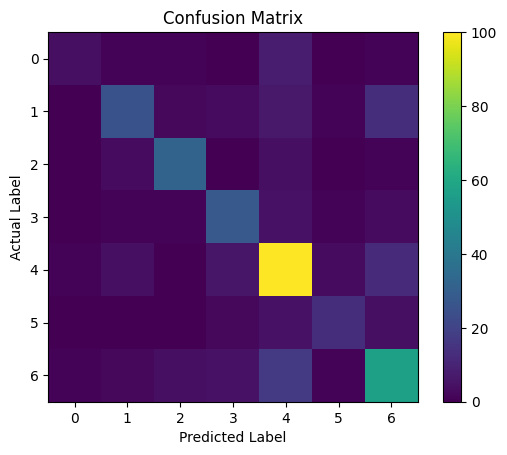

In [26]:
# Create a heatmap
plt.imshow(cm, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

# Show the plot
plt.show()